# Producing the Transfer Functions

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

## Notebook Initialization

In [2]:
%autoreload
import numpy as np
import pickle
from tqdm import tqdm_notebook as tqdm

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
import darkhistory.physics as phys
import darkhistory.utilities as utils

from scipy.interpolate import interp1d

# np.set_printoptions(threshold=np.nan)

## Import Raw Data

In [3]:
xes_str = [
    '4.540E-05', '2.746E-04', '1.659E-03', '9.952E-03', '5.732E-02',
    '2.689E-01', '6.900E-01', '9.309E-01', '9.879E-01', '9.980E-01',
    '9.997E-01'
    
]

# xes_str = ['2.746E-04']

file_names = [
    '/Users/hongwan/Dropbox (MIT)/Photon Deposition/'
    +'full_transferfunctions_coarse/'
    +'transferfunction_withloweng_cmbloss_60eV_fixed_binning_complete_coarse_xe_'
    +str+'_nointerp.p'
    for str in xes_str    
]

raw_tf_tuple = [pickle.load(open(file_name, "rb")) for file_name in file_names]

raw_tf_list = [tup[0] for tup in raw_tf_tuple]
CMB_engloss_list = [tup[1] for tup in raw_tf_tuple]

## Raw Data Manipulation

The raw data is a large array with no abscissa values included. We need to create the abscissae related to this large array (the abscissa of photon energies and electron energies). 

First, we swap some of the axes. The initial array has dimensions corresponding to (injected photon energy, redshift, outgoing energy, type), where type is high-energy photons, low-energy photons and low-energy electrons respectively. 

In [4]:
for i in np.arange(len(raw_tf_list)):
    raw_tf_list[i] = np.swapaxes(raw_tf_list[i], 0, 1)
    raw_tf_list[i] = np.flip(raw_tf_list[i], axis=0)
    
for i in np.arange(len(CMB_engloss_list)):
    CMB_engloss_list[i] = np.transpose(CMB_engloss_list[i])
    
CMB_engloss = np.array(CMB_engloss_list)

CMB_engloss = np.flip(CMB_engloss,1)

At this point, the transfer function `raw_tf_list` is listed in the following order: (redshift, input photon energy, output energy, type), and the order is in decreasing redshift.

`CMB_engloss` is in the order (redshift, input energy), order in decreasing redshift.

The abscissa for the transfer functions are as follows. For the injected photon energy and redshifts,

In [5]:
# Input energy abscissa. 
# in_eng_step = 501
in_eng_step = 51
# in_eng_low = 3e3 + 100.
in_eng_low = 60
in_eng_upp = 5e3 * np.exp(39 * np.log(1e13/5e3) / 40)

in_eng_arr = (
    in_eng_low * np.exp((np.arange(in_eng_step)) * 
              np.log(in_eng_upp/in_eng_low) / in_eng_step)
)

in_eng_arr = in_eng_arr[1:]
# Added for the coarse, fixed binning
in_eng_arr = np.insert(in_eng_arr, 0, 61.)

# Redshift abscissa, decreasing order. 
# rs_step = 50
# rs_upp  = 31
rs_step = 51
rs_upp = 3000
rs_low  = 4

# log_rs = (
#     np.log(rs_low) + (np.arange(rs_step)+1)
#     *(np.log(rs_upp) - np.log(rs_low))/rs_step
# )

# log_rs = np.insert(log_rs, 0, np.log(4.))

log_rs = (
    np.log(rs_low) + (np.arange(rs_step))
    *(np.log(rs_upp) - np.log(rs_low))/rs_step
)

log_rs_arr = np.flipud(log_rs)

# xe abscissa

xe = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])

The output abscissa depends on the injection energy, and are different for photons and electrons. We write these as functions of the injection energy for convenience.

In [6]:
upp_bin = in_eng_arr[-1]
print(upp_bin)
me = 510998.903
log_bin_width = np.log(upp_bin)/500
bin_boundary= me + np.exp(np.arange(501) * log_bin_width)
bin_boundary_low = bin_boundary[0:500]
bin_boundary_upp = bin_boundary[1:501]
np.sqrt((bin_boundary_low - me) * (bin_boundary_upp - me))

3564489408122.1504


array([1.02932376e+00, 1.09057614e+00, 1.15547349e+00, 1.22423272e+00,
       1.29708362e+00, 1.37426970e+00, 1.45604892e+00, 1.54269460e+00,
       1.63449635e+00, 1.73176098e+00, 1.83481357e+00, 1.94399856e+00,
       2.05968086e+00, 2.18224711e+00, 2.31210697e+00, 2.44969444e+00,
       2.59546939e+00, 2.74991903e+00, 2.91355956e+00, 3.08693792e+00,
       3.27063357e+00, 3.46526048e+00, 3.67146912e+00, 3.88994870e+00,
       4.12142944e+00, 4.36668499e+00, 4.62653507e+00, 4.90184815e+00,
       5.19354439e+00, 5.50259871e+00, 5.83004406e+00, 6.17697483e+00,
       6.54455055e+00, 6.93399974e+00, 7.34662404e+00, 7.78380254e+00,
       8.24699640e+00, 8.73775372e+00, 9.25771473e+00, 9.80861727e+00,
       1.03923026e+01, 1.10107215e+01, 1.16659409e+01, 1.23601507e+01,
       1.30956712e+01, 1.38749605e+01, 1.47006234e+01, 1.55754193e+01,
       1.65022720e+01, 1.74842793e+01, 1.85247233e+01, 1.96270815e+01,
       2.07950381e+01, 2.20324967e+01, 2.33435933e+01, 2.47327099e+01,
      

In [7]:
def get_out_photeng(in_eng):
    
    log_bin_width = np.log((phys.me*0 + in_eng)/1e-4)/500
    bin_boundary  = 1e-4 * np.exp(np.arange(501) * log_bin_width)
    bin_boundary_low = bin_boundary[0:500]
    bin_boundary_upp = bin_boundary[1:501]

    return np.sqrt(bin_boundary_low * bin_boundary_upp)

def get_out_eleceng(in_eng):
    
    log_bin_width = np.log(in_eng)/500
    bin_boundary  = phys.me + np.exp(np.arange(501) * log_bin_width)
    bin_boundary_low = bin_boundary[:500]
    bin_boundary_upp = bin_boundary[1:]
    return np.sqrt(
        (bin_boundary_low - phys.me)*(bin_boundary_upp - phys.me)
    )    

The transfer function is calculated by injecting 2 photons at the input energy abscissa. However, the first step is to assign $x$ photons to the top bin of the *output* photon abscissa, such that $x$ times the energy of the top bin is 2 times the injection energy. Because of the misalignment between the two abscissae, as well as the fact that we want to transfer function for a single electron, we have to normalize the results first.

First, we construct two arrays: a list of output abscissae (for both photons and electrons) given the injection abscissa, and a list of the energy of the *output* photon energy bin where the injected photons are assigned to. Then we compute the normalization factor. 

In [8]:
# dimensions input x output
# output energy abscissae
# toggle for fixed binning. 
# out_photeng_arr = np.array([get_out_photeng(eng) for eng in in_eng_arr])
out_photeng_arr = np.array([get_out_photeng(in_eng_arr[-1]) for eng in in_eng_arr])
# dimensions input x output
# out_eleceng_arr = np.array([get_out_eleceng(eng) for eng in in_eng_arr])
out_eleceng_arr = np.array([get_out_eleceng(in_eng_arr[-1]) for eng in in_eng_arr])
# get bin widths

out_photeng_bin_width_arr = np.diff(np.log(out_photeng_arr))
out_photeng_bin_width_arr = np.insert(out_photeng_bin_width_arr, 0, out_photeng_bin_width_arr[:,0], axis=1)
out_photeng_bin_width_arr *= out_photeng_arr

# out_photeng_bin_bound_arr = np.array([spectools.get_bin_bound(photeng_arr) for photeng_arr in out_photeng_arr])
out_eleceng_bin_bound_arr = np.array([spectools.get_bin_bound(eleceng_arr) for eleceng_arr in out_eleceng_arr])
# out_photeng_bin_width_arr = np.diff(out_photeng_bin_bound_arr, axis=-1)
out_eleceng_bin_width_arr = np.diff(out_eleceng_bin_bound_arr, axis=-1)


# dimensions input
# original injection energies
top_photeng_bin_arr = np.array(
    [
        photeng[photeng < eng][-1] 
        for eng,photeng in zip(in_eng_arr, out_photeng_arr)
    ]
)

# pad top_photeng_bin_arr to go down to 1e-4

# dimensions input
norm_fac_arr = in_eng_arr/top_photeng_bin_arr*2

Dividing by the normalization factor gives the spectra for the injection of 1 photon, with energy given by `top_photeng_bin_arr`. 

Now we construct a raw array of all of the transfer functions, on which we will perform an interpolation to extract a set of transfer functions for use, given a chosen abscissa.

The final dimension of these lists is (xe, in_eng, rs, out_eng)

In [9]:
# Multiplying by bin width converts all the eleceng array into number of particles. 

phot_tf_raw = np.array([
    [
        [raw_tf[i,j,:,0]/norm_fac*bin_width for (i, log_rs) in enumerate(log_rs_arr)]
        for (j, (in_eng, norm_fac, bin_width)) in enumerate(zip(in_eng_arr, norm_fac_arr, out_photeng_bin_width_arr))
    ] for raw_tf in tqdm(raw_tf_list)
])

lowengphot_tf_raw = np.array([
    [
        [raw_tf[i,j,:,1]/norm_fac*bin_width for (i, log_rs) in enumerate(log_rs_arr)]
        for (j, (in_eng, norm_fac, bin_width)) in enumerate(zip(in_eng_arr, norm_fac_arr, out_photeng_bin_width_arr))
    ] for raw_tf in tqdm(raw_tf_list)
])

lowengelec_tf_raw = np.array([
    [
        [raw_tf[i,j,:,2]/norm_fac*bin_width for (i, log_rs) in enumerate(log_rs_arr)]
        for (j, (in_eng, norm_fac, bin_width)) in enumerate(zip(in_eng_arr, norm_fac_arr, out_eleceng_bin_width_arr))
    ] for raw_tf in tqdm(raw_tf_list)
])

CMB_engloss = CMB_engloss/norm_fac_arr

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

In [10]:
raw_tf_list[0].shape

(51, 51, 500, 3)

## Generating the Transfer Functions

(11, 51, 51, 500)


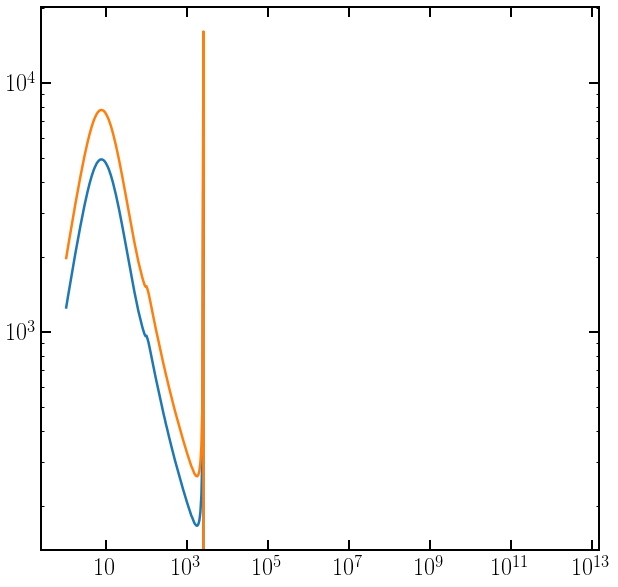

In [11]:
print(phot_tf_raw.shape)

injE_ind = 46

plt.figure()

plt.plot(out_eleceng_arr[injE_ind], lowengelec_tf_raw[0,injE_ind,0,:])
plt.plot(out_eleceng_arr[injE_ind+1], lowengelec_tf_raw[0,injE_ind+1,0,:])

ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')

In [12]:
np.where(np.isnan(phot_tf_raw))

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [13]:
# indices where the old injection energy binning lies above 3keV.
ind_photeng_above_3keV = np.where(top_photeng_bin_arr > 3000)[0][0]


Now we build the transfer functions, given some initial abscissa that will be used throughout the code. The right thing to do is simply to interpolate directly over the raw arrays above, as a function of the injection energy. 

In [14]:
print(top_photeng_bin_arr)
print(phot_tf_raw.shape)
print(CMB_engloss.shape)
print(ind_photeng_above_3keV)

[5.97925489e+01 9.44650232e+01 1.61064192e+02 2.54462017e+02
 4.33861316e+02 6.85448605e+02 1.16869950e+03 1.84640440e+03
 3.14814545e+03 4.97369051e+03 8.48021221e+03 1.33977136e+04
 2.28432899e+04 3.60896457e+04 6.15333531e+04 9.72152840e+04
 1.65753425e+05 2.61870441e+05 4.46492782e+05 7.05404800e+05
 1.20272510e+06 1.90016074e+06 3.23980077e+06 5.11849486e+06
 8.72710566e+06 1.37877755e+07 2.35083509e+07 3.71403620e+07
 6.33248391e+07 1.00045616e+08 1.70579181e+08 2.69494554e+08
 4.59492002e+08 7.25942001e+08 1.23774131e+09 1.95548214e+09
 3.33412454e+09 5.26751505e+09 8.98118718e+09 1.41891937e+10
 2.41927746e+10 3.82216689e+10 6.51684826e+10 1.02958351e+11
 1.75545435e+11 2.77340636e+11 4.72869682e+11 7.47077124e+11
 1.27377699e+12 2.01241418e+12 3.43119445e+12]
(11, 51, 51, 500)
(11, 51, 51)
8


In [ ]:
# We will use the last binning as the photon and electron abscissa as an example.
photeng = out_photeng_arr[-1]
eleceng = out_eleceng_arr[-1]

# photeng = photeng[1::5]

photeng_low  = photeng[photeng <= 60]
photeng_high = photeng[photeng > 60]

# Indices where the new injection energy lies above 3keV.
new_ind_photeng_above_3keV = np.where(photeng_high > 3000)[0][0]

print('Creating high energy photon transfer function interpolation table...')
new_phot_tf_raw_interp = interp1d(np.log(top_photeng_bin_arr), phot_tf_raw, axis=1)

print('Creating low energy photon transfer function interpolation table...')

new_lowengphot_below_3keV_tf_raw_interp = interp1d(
    np.log(top_photeng_bin_arr[:ind_photeng_above_3keV]),
    lowengphot_tf_raw[:, :ind_photeng_above_3keV, :, :],
    bounds_error = False, fill_value = (np.nan, lowengphot_tf_raw[:, ind_photeng_above_3keV-1, :, :]),
    axis=1
)

new_lowengphot_above_3keV_tf_raw_interp = interp1d(
    np.log(top_photeng_bin_arr[ind_photeng_above_3keV:]), 
    lowengphot_tf_raw[:, ind_photeng_above_3keV:, :, :],
    bounds_error = False, fill_value = (lowengphot_tf_raw[:, ind_photeng_above_3keV, :, :], np.nan),
    axis=1
)



# The interpolation is split because of the sudden transition between photoionizers below 3keV
# (immediately gets output) vs. photoionizers above 3keV (produces electrons first)

print('Creating low energy electron transfer function interpolation table...')
new_lowengelec_below_3keV_tf_raw_interp = interp1d(
    np.log(top_photeng_bin_arr[:ind_photeng_above_3keV]), 
    lowengelec_tf_raw[:,:ind_photeng_above_3keV,:,:], 
    bounds_error = False, fill_value = (np.nan, lowengelec_tf_raw[:,ind_photeng_above_3keV-1,:,:]),
    axis=1
)

new_lowengelec_above_3keV_tf_raw_interp = interp1d(
    np.log(top_photeng_bin_arr[ind_photeng_above_3keV:]), 
    lowengelec_tf_raw[:,ind_photeng_above_3keV:,:,:], 
    bounds_error = False, fill_value = (lowengelec_tf_raw[:,ind_photeng_above_3keV,:,:], np.nan),
    axis=1
)

print('Creating CMB loss table...')
new_cmbloss_interp = interp1d(np.log(top_photeng_bin_arr), CMB_engloss, axis=2)
print('Interpolation tables created!')

print('Interpolating high energy photon transfer functions...')
new_phot_tf_raw = new_phot_tf_raw_interp(np.log(photeng_high))

print('Interpolating low energy photon transfer functions...')
new_lowengphot_below_3keV_tf_raw = new_lowengphot_below_3keV_tf_raw_interp(
    np.log(photeng_high[:new_ind_photeng_above_3keV])
)

new_lowengphot_above_3keV_tf_raw = new_lowengphot_above_3keV_tf_raw_interp(
    np.log(photeng_high[new_ind_photeng_above_3keV:]*(1-1e-12))
)



print('Interpolating low energy electron transfer functions...')
new_lowengelec_below_3keV_tf_raw = new_lowengelec_below_3keV_tf_raw_interp(
    np.log(photeng_high[:new_ind_photeng_above_3keV])
)
new_lowengelec_above_3keV_tf_raw = new_lowengelec_above_3keV_tf_raw_interp(
    np.log(photeng_high[new_ind_photeng_above_3keV:]*(1-1e-12))
)

print('Concatenating the low energy interpolation results...')
new_lowengphot_tf_raw = np.concatenate([new_lowengphot_below_3keV_tf_raw, new_lowengphot_above_3keV_tf_raw], axis=1)
new_lowengelec_tf_raw = np.concatenate([new_lowengelec_below_3keV_tf_raw, new_lowengelec_above_3keV_tf_raw], axis=1)

print('Interpolating CMB loss table...')
new_cmbloss_raw = new_cmbloss_interp(np.log(photeng_high))
print('Interpolation complete!')

new_out_photeng_interp = interp1d(np.log(top_photeng_bin_arr), np.log(out_photeng_arr), axis=0)
new_out_eleceng_interp = interp1d(np.log(top_photeng_bin_arr), np.log(out_eleceng_arr), axis=0)
new_out_photeng_arr = np.exp(new_out_photeng_interp(np.log(photeng_high)))
new_out_eleceng_arr = np.exp(new_out_eleceng_interp(np.log(photeng_high)))

Creating high energy photon transfer function interpolation table...
Creating low energy photon transfer function interpolation table...
Creating low energy electron transfer function interpolation table...
Creating CMB loss table...
Interpolation tables created!
Interpolating high energy photon transfer functions...
Interpolating low energy photon transfer functions...


In [ ]:
print(np.where(np.isnan(new_lowengelec_tf_raw)))
print(np.where(np.isnan(new_lowengphot_tf_raw)))
print(new_lowengelec_above_3keV_tf_raw[0,-1,50,:])
print(new_lowengelec_above_3keV_tf_raw.shape)
print(photeng_high)
print(top_photeng_bin_arr[ind_photeng_above_3keV:])

In [ ]:
# plt.figure()

# injE_ind = 141
# new_injE_ind = 91

# print(top_photeng_bin_arr[injE_ind-1])
# print(top_photeng_bin_arr[injE_ind])
# print(photeng_high[new_injE_ind])


# plt.plot(out_photeng_arr[injE_ind-1], phot_tf_raw[0,injE_ind-1,0,:])
# plt.plot(out_photeng_arr[injE_ind], phot_tf_raw[0,injE_ind,0,:])
# plt.plot(new_out_photeng_arr[new_injE_ind], new_phot_tf_raw[0,new_injE_ind,0,:])


# ax = plt.gca()

# ax.set_xscale('log')
# ax.set_yscale('log')
# plt.axis([1e4, 1e5, 1e-42, 1e-1])

Now, we construct the list of `Spectrum` objects from our raw array of transfer functions...

In [ ]:
# spec_type = 'N' for eleceng, because we have already multiplied in the bin width earlier. 

photspec_list = [
    [
        [
            Spectrum(
                out_photeng, phot_tf[i,j,:], spec_type='N', 
                rs = np.exp(log_rs), in_eng = in_eng
            ) for (j, log_rs) in enumerate(log_rs_arr)
        ] for (i, (in_eng, out_photeng)) in enumerate(
            zip(photeng_high, new_out_photeng_arr)
        )
    ] for phot_tf in tqdm(new_phot_tf_raw)
]

lowengphotspec_list = [
    [
        [
            Spectrum(
                out_photeng, lowengphot_tf[i,j,:], spec_type='N',
                rs = np.exp(log_rs), in_eng = in_eng
            ) for (j, log_rs) in enumerate(log_rs_arr)
        ] for (i, (in_eng, out_photeng)) in enumerate(zip(photeng_high, new_out_photeng_arr))
    ] for lowengphot_tf in tqdm(new_lowengphot_tf_raw)
]

lowengelecspec_list = [
    [
        [
            Spectrum(
                out_eleceng, lowengelec_tf[i,j,:], spec_type='N',
                rs = np.exp(log_rs), in_eng = in_eng
            ) for (j, log_rs) in enumerate(log_rs_arr)
        ] for (i, (in_eng, out_eleceng)) in enumerate(zip(photeng_high, new_out_eleceng_arr))
    ] for lowengelec_tf in tqdm(new_lowengelec_tf_raw)
]


... and rebin the `Spectrum` objects into the abscissa specified in `photeng`.

In [ ]:
# switch_spec_type to make all of the Spectrum objects of spec_type = 'N'

for phot_specs_xe in tqdm(photspec_list):
    for phot_specs in tqdm(phot_specs_xe):
        for phot_spec in phot_specs:
            phot_spec.rebin(photeng)
#             phot_spec.switch_spec_type()
            
for lowengphot_specs_xe in tqdm(lowengphotspec_list):
    for lowengphot_specs in tqdm(lowengphot_specs_xe):
        for phot_spec in lowengphot_specs:
            phot_spec.rebin(photeng)
#             phot_spec.switch_spec_type()
            
for lowengelec_specs_xe in tqdm(lowengelecspec_list):
    for lowengelec_specs in tqdm(lowengelec_specs_xe):
        for elec_spec in lowengelec_specs:
            elec_spec.rebin(eleceng)
#             elec_spec.switch_spec_type()

In [ ]:
test = lowengphotspec_list[0][100][3]
print(test.in_eng)
print(test.eng[273])

Finally, we can construct the `TransferFuncList` from this.

In [ ]:
tfunclist_photspec_list = [
    tflist.TransferFuncList(
        [
            tf.TransFuncAtEnergy(spec_arr, dlnz=0.002)
            for spec_arr in photspec_xe
        ]
    ) for photspec_xe in tqdm(photspec_list)
]

tfunclist_lowengphotspec_list = [
    tflist.TransferFuncList(
        [
            tf.TransFuncAtEnergy(spec_arr, dlnz=0.002)
            for spec_arr in lowengphotspec_xe
        ]
    ) for lowengphotspec_xe in tqdm(lowengphotspec_list)
]
    

tfunclist_lowengelecspec_list = [
    tflist.TransferFuncList(
        [
            tf.TransFuncAtEnergy(spec_arr, dlnz=0.002)
            for spec_arr in lowengelecspec_xe
        ]
    ) for lowengelecspec_xe in tqdm(lowengelecspec_list)
]

We will now transpose all of the `TransferFuncList` objects so that they are now all of type `'rs'`.

In [ ]:
for tflist_hep, tflist_lep, tflist_lee in zip(
    tfunclist_photspec_list, tfunclist_lowengphotspec_list, tfunclist_lowengelecspec_list):
    tflist_hep.transpose()
    tflist_lep.transpose()
    tflist_lee.transpose()
    for i, tf_hep, tf_lep, tf_lee in zip(np.arange(327), tflist_hep, tflist_lep, tflist_lee):
        if np.any(np.isnan(tf_hep._grid_vals)):
            print(np.where(np.isnan(tf_hep._grid_vals)),'here!')
        if np.any(np.isnan(tf_lep._grid_vals)):
            print(np.where(np.isnan(tf_lep._grid_vals)),'here1!')
        if np.any(np.isnan(tf_lee._grid_vals)):
            print(np.where(np.isnan(tf_lee._grid_vals)),'here2!')
        
        tf_hep._grid_vals[np.where(tf_hep.grid_vals < 0)] = 1e-100
        tf_lep._grid_vals[np.where(tf_lep.grid_vals < 0)] = 1e-100
        tf_lee._grid_vals[np.where(tf_lee.grid_vals < 0)] = 1e-100

In [ ]:
test = tfunclist_photspec_list[-1][0]

plt.figure()

ax = plt.gca()

# test.plot(ax, ind=(0,327), step=2)
# test.plot(ax, ind=(48, 51), step=1)

ax.set_xscale('log')
ax.set_yscale('log')
plt.axis([1e-4, 7e12, 1e-42, 1e7])

In [ ]:
test.in_eng[49]

In [ ]:
test = tfunclist_lowengphotspec_list[-1][30]

plt.figure()

ax = plt.gca()

# test.plot(ax, ind=(0, 326), step=1)

ax.set_xscale('log')
ax.set_yscale('log')
plt.axis([1e-4, 5e12, 1e-42, 3e2])

In [ ]:
test = tfunclist_lowengelecspec_list[-1][0]

plt.figure()

ax = plt.gca()

# test.plot(ax, ind=(0, 326), step=1)
# test.plot(ax, ind=np.array([50]))
ax.set_xscale('log')
ax.set_yscale('log')
plt.axis([1e-1, 4e3, 1e-12, 1e2])

In [ ]:
tfunclist_lowengelecspec_list[-1][0].in_eng[76]

Save the transfer functions.

In [ ]:
pickle.dump(tfunclist_photspec_list, 
           open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tfunclist_photspec_60eV_complete_coarse.raw", "wb")
           )

pickle.dump(tfunclist_lowengphotspec_list, 
           open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tfunclist_lowengphotspec_60eV_complete_coarse.raw", "wb")
           )

pickle.dump(tfunclist_lowengelecspec_list, 
           open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tfunclist_lowengelecspec_60eV_complete_coarse.raw", "wb")
           )

pickle.dump(
    new_cmbloss_raw, 
    open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/CMB_engloss_60eV_complete_coarse.raw", "wb")       
           )